In [1]:
import sys
import numpy as np
import torch

# sys.path.insert(0,"..")
from dataloader import dataloader
device = torch.device("cuda")
tmp = dataloader(r"..\data\clover")
imu, rotor, mocap = tmp.runPipeline()
tmp.homogenizeData()
data = tmp.ConcatData
print(device)


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO]  Data folder c:\Users\aniru\Documents\01_UPenn\04_ESE6500\02_Homework\05_Project\DeepIO\data\clover\yawConstant\New folder\rosbag already exists. Not creating.


100%|██████████| 1/1 [00:12<00:00, 12.71s/it]


cuda


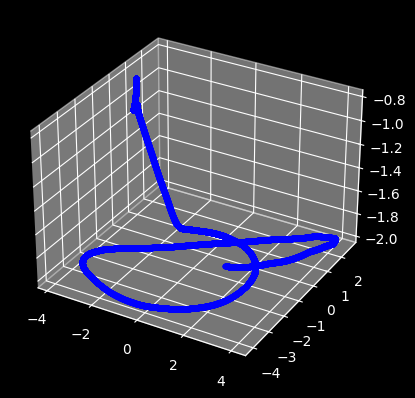

In [2]:
import matplotlib.pyplot as plt


x1, y1, z1 = data['pose.position.x'].to_numpy(
), data['pose.position.y'].to_numpy(), data['pose.position.z'].to_numpy()
xA1, yA1, zA1 = data['psi'].to_numpy(
), data['theta'].to_numpy(), data['phi'].to_numpy()
dt = np.append(0, np.diff(data['Time'].to_numpy()))
r1, r2, r3, r4 = data['rpm_0'].to_numpy(), data['rpm_1'].to_numpy(
), data['rpm_2'].to_numpy(), data['rpm_3'].to_numpy()


TrajectorySize = 25000  # 15*350
TrainTrajectorySize = int(0.8*TrajectorySize)
St = 0  # Start index


xTrain = np.stack((r1[St:St + TrajectorySize], r2[St:St + TrajectorySize],
                  r3[St:St + TrajectorySize], r4[St:St + TrajectorySize], dt[St:St + TrajectorySize]), axis=1)
yTrain = np.stack((x1[St:St + TrajectorySize], y1[St:St + TrajectorySize], z1[St:St + TrajectorySize],
                   xA1[St:St + TrajectorySize], yA1[St:St + TrajectorySize], zA1[St:St + TrajectorySize]), axis=1)


# torch.tensor(xTrain[:7000], dtype=torch.float32)
train_x = xTrain[:TrainTrajectorySize]
# torch.tensor(yTrain[:7000], dtype=torch.float32)
train_y = yTrain[:TrainTrajectorySize]
# torch.tensor(xTrain[7000:], dtype=torch.float32)
test_x = xTrain[TrainTrajectorySize:]
# torch.tensor(yTrain[7000:], dtype=torch.float32)
test_y = yTrain[TrainTrajectorySize:]

xTrain = torch.tensor(xTrain, device=device)
yTrain = torch.tensor(yTrain, device=device)
train_x = torch.tensor(train_x, device=device)
train_y = torch.tensor(train_y, device=device)
test_x = torch.tensor(test_x, device=device)
test_y = torch.tensor(test_y, device=device)

ax = plt.figure().add_subplot(projection='3d')
ax.plot(train_y[:, 0].cpu().numpy(), train_y[:, 1].cpu(
).numpy(), train_y[:, 2].cpu().numpy(), '.b')


In [22]:
#### NODE #####

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib.pyplot as plt

method = 'dopri5'
batch_time = 45
batch_size = TrainTrajectorySize-100
niters = 200000
test_freq = 10000
viz = 'store_true'
adjoint = 'store_true'


# def mini_batch(yTrain, xTrain, size, batch_size, batch_time):

#     s = torch.from_numpy(np.random.choice(
#         np.arange(size-batch_time, dtype=np.int64), batch_size, replace=False))
#     batch_y0 = xTrain[s, :4]
#     batch_x = xTrain[:batch_time, 4]
#     batch_y = torch.stack([torch.Tensor(xTrain[s + i, :4])
#                           for i in range(batch_time)], dim=0)
#     batch_yy = yTrain[s, :]
#     batch_yy1 = yTrain[s+1, :]

#     return batch_y0, batch_x, batch_y, batch_yy, batch_yy1

def mini_batch(yTrain, xTrain, size, batch_size, batch_time):
    device = torch.device("cuda")
    s = torch.randint(0, size-batch_time, (batch_size,),
                      dtype=torch.int64, device=device)
    batch_y0 = xTrain[s, :4]
    batch_x = xTrain[:batch_time, 4]
    batch_y = torch.stack([xTrain[s + i, :4]
                          for i in range(batch_time)], dim=0)
    batch_yy = yTrain[s, :]
    batch_yy1 = yTrain[s+1, :]

    return batch_y0, batch_x, batch_y, batch_yy, batch_yy1

# def TrainNODENetwork(yTrain, xTrain, size, batch_size, batch_time, FuncControl, FuncDynamics, niters=13000,):

#     parameters = list(FuncControl.parameters()) + \
#         list(FuncDynamics.parameters())
#     # optimizerD = optim.Adam(params=parameters, lr=1e-3)
#     optimizer = optim.Adadelta(
#         params=parameters, lr=1, rho=0.9, eps=1e-06, weight_decay=0)

#     for itr in range(1, niters + 1):
#         optimizer.zero_grad()
#         batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
#             yTrain, xTrain, size, batch_size, batch_time)
#         # pred_y = odeint(FuncControl, torch.Tensor(
#             # batch_y0).to(device = 'cuda:0'), torch.Tensor(batch_x))

#         XDynamics = torch.cat((batch_y0, batch_yy), 1).to(
#             device='cuda:0')  # pred_y[1,:,:]
#         pred_yy = FuncDynamics(XDynamics).to(device='cuda:0', dtype=torch.float64)
#         lossD = torch.mean(
#             torch.abs(pred_yy - batch_yy1))
#         # lossC = torch.mean(torch.abs(pred_y - torch.Tensor(batch_y)))

#         loss = lossD  # + lossC
#         loss.backward()
#         optimizer.step()

#         if itr % test_freq == 0:
#             '''with torch.no_grad():
#                 pred_y = odeint(Func, torch.Tensor(y0[1,:]), t)
#                 loss = torch.norm(pred_y - torch.Tensor(y[:,1,:]))'''
#             print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

#     return FuncControl, FuncDynamics


class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 4),
        )
        self.net = self.net.float()
        self.net.apply(self._apply_wt_init)

    def forward(self, t, y):
        return self.net(y)

    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)


class Func2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # nn.BatchNorm1d(10),
            nn.Linear(10, 175),
            nn.LeakyReLU(),
            nn.BatchNorm1d(175),
            nn.Linear(175, 35),
            nn.LeakyReLU(),
            nn.BatchNorm1d(35),
            nn.Linear(35, 6),
        )
        self.net = self.net.to(dtype=torch.float64)
        self.net.apply(self._apply_wt_init)

    def forward(self, y):
        return self.net(y)

    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)


FuncControl = ODEFunc().to(device=device)
FuncDynamics = Func2().to(device=device)

train_y = torch.tensor(train_y, device=device)
train_x = torch.tensor(train_x, device=device)


# FuncControl, FuncDynamics = TrainNODENetwork(
#     train_y, train_x, TrainTrajectorySize, batch_size, batch_time, FuncControl, FuncDynamics)


C:\Users\aniru\AppData\Local\Temp\ipykernel_2852\3046507071.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, device=device)
C:\Users\aniru\AppData\Local\Temp\ipykernel_2852\3046507071.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(train_x, device=device)


In [23]:
parameters = list(FuncControl.parameters()) + list(FuncDynamics.parameters())
optimizer = optim.Adadelta(params=parameters, lr=0.1,
                           rho=0.9, eps=1e-06, weight_decay=0)

batchy0s = []
batchxs = []
batchys = []
batchyys = []
batchyy1s = []

# for itr in range(1, niters + 1):
#     batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
#         yTrain, xTrain, TrainTrajectorySize, batch_size, batch_time)
#     batchy0s.append(batch_y0)
#     batchxs.append(batch_x)
#     batchys.append(batch_y)
#     batchyys.append(batch_yy)
#     batchyy1s.append(batch_yy1)
niters = 5000
test_freq = 1000
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    # batch_y0 = batchy0s[itr-1]
    # batch_x = batchxs[itr-1]
    # batch_y = batchys[itr-1]
    # batch_yy = batchyys[itr-1]
    # batch_yy1 = batchyy1s[itr-1]

    batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
        yTrain, xTrain, TrainTrajectorySize, batch_size, batch_time)

    XDynamics = torch.cat([batch_y0, batch_yy], dim=1)
    pred_yy = FuncDynamics(XDynamics)
    loss = torch.mean(torch.abs(pred_yy - batch_yy1))

    loss.backward()
    optimizer.step()

    if itr % test_freq == 0:
        print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))


Iter 1000 | Total Loss 0.366187
Iter 2000 | Total Loss 0.305723
Iter 3000 | Total Loss 0.203329
Iter 4000 | Total Loss 0.143418
Iter 5000 | Total Loss 0.107935


In [6]:
from copy import deepcopy


In tensor([-3.4840,  0.3846, -0.7709,  1.5647,  0.0230, -0.0042], device='cuda:0',
       dtype=torch.float64)
Out: [-3.3624747   0.09309628 -0.85974415  1.53933214 -0.05362345 -0.023037  ]
In tensor([-3.3625,  0.0931, -0.8597,  1.5393, -0.0536, -0.0230], device='cuda:0',
       dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)
Out: [-3.34143691  0.03729316 -0.86300494  1.52012264 -0.03832653 -0.00414114]
In tensor([-3.3414,  0.0373, -0.8630,  1.5201, -0.0383, -0.0041], device='cuda:0',
       dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)
Out: [-3.33736343e+00  2.52690498e-02 -8.63534764e-01  1.51671179e+00
 -3.56149882e-02 -8.82667688e-04]
In tensor([-3.3374e+00,  2.5269e-02, -8.6353e-01,  1.5167e+00, -3.5615e-02,
        -8.8267e-04], device='cuda:0', dtype=torch.float64,
       grad_fn=<ReshapeAliasBackward0>)
Out: [-3.33650470e+00  2.27199571e-02 -8.63644483e-01  1.51600027e+00
 -3.50463255e-02 -2.00160657e-04]
In tensor([-3.3365e+00,  2.2720e-02, -8.6364e-01,  1.5160e+

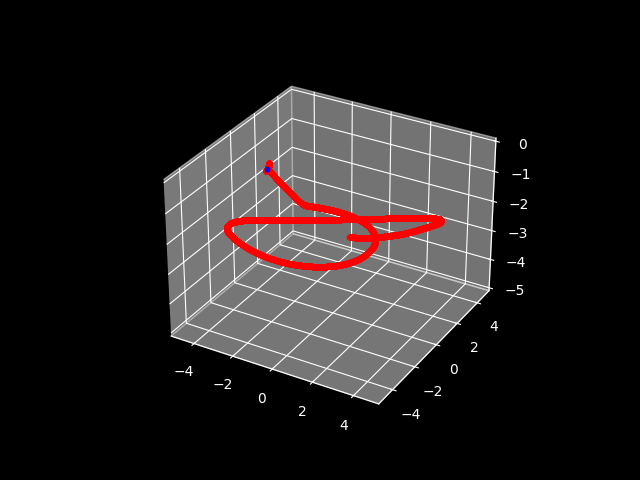

In [27]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
ax.plot(train_y[::2, 0].cpu().detach().numpy(), train_y[::2, 1].cpu(
).detach().numpy(), train_y[::2, 2].cpu().detach().numpy(), '.r')

y0 = train_y[0, :]
u0 = train_x[0, :4]
FuncDynamics.eval()
x = []
y = []
z = []
for i in range(TrainTrajectorySize):

    # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))

    u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
    if i % 500 == 0:
        m = deepcopy(train_y[i, :])

        # m[0] += (np.random.uniform()-0.5)
        # m[1] += (np.random.uniform()-0.5)
        # m[2] += (np.random.uniform()-0.5)
    else:
        m = pred_y
    # print("In",m)
    XDynamics = torch.cat(
        (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
    pred_y = FuncDynamics(XDynamics).flatten()
    y0 = pred_y.to('cpu').detach().numpy()
    # print("Out:", y0)
    # if i == 5:
    #     break
    x.append(y0[0])
    y.append(y0[1])
    z.append(y0[2])

ax.scatter(x[0::2], y[::2], z[::2], s=8, c='b')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.gca().set_zlim([-5, 0])
plt.show()


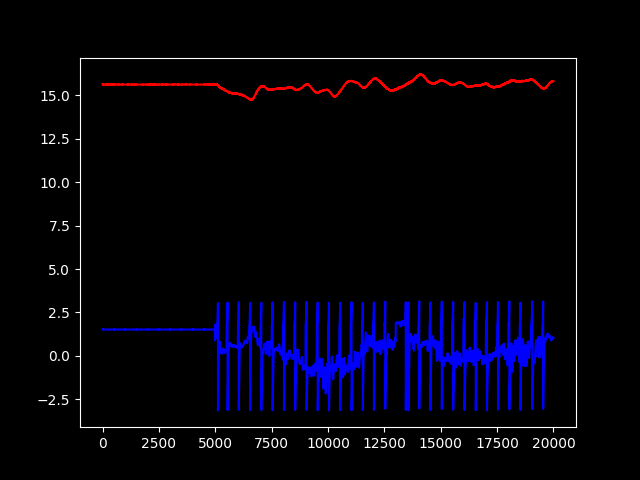

In [34]:
%matplotlib widget
plt.figure()
xt = []
yt = []
zt = []

y0 = train_y[0, :]
u0 = train_x[0, :4]
FuncDynamics.eval()
x = []
y = []
z = []
for i in range(TrainTrajectorySize):

    # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))

    u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
    if i % 500 == 0:
        m = deepcopy(train_y[i, :])

        # m[0] += (np.random.uniform()-0.5)
        # m[1] += (np.random.uniform()-0.5)
        # m[2] += (np.random.uniform()-0.5)
    else:
        m = pred_y
    # print("In",m)
    XDynamics = torch.cat(
        (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
    pred_y = FuncDynamics(XDynamics).flatten()
    y0 = pred_y.to('cpu').detach().numpy()
    y0[3:] = np.arctan2(np.sin(y0[3:]), np.cos(y0[3:]))
    # print("Out:", y0)
    # if i == 5:
    #     break
    x.append(y0[3])
    y.append(y0[4])
    z.append(y0[5])
    xt.append(train_y[i, 3].cpu().detach().numpy())
    yt.append(train_y[i, 4].cpu().detach().numpy())
    zt.append(train_y[i, 5].cpu().detach().numpy())

plt.plot(np.array(xt)*10, 'r')
plt.plot(x, 'b')


plt.show()


In [ ]:
plt.figure()
plt.plot(yt, 'r')
plt.plot(y, 'b')
plt.show()


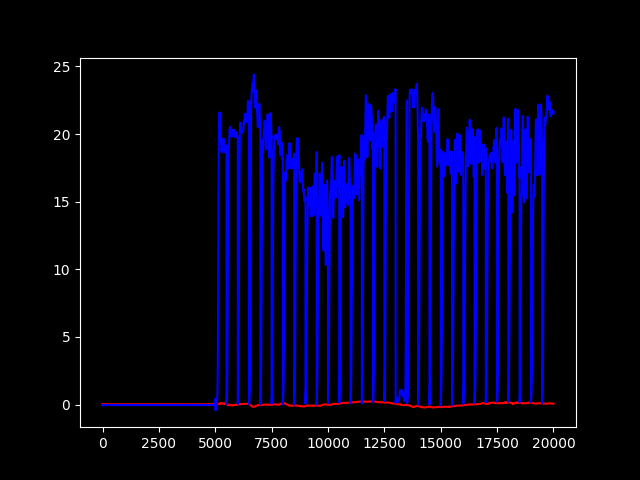

In [32]:
plt.figure()
plt.plot(yt, 'r')
plt.plot(y, 'b')
plt.show()


In [5]:
torch.save(FuncDynamics.state_dict(), 'FuncDynamics2.pt')


In [26]:
loadModel = Func2().to(device=device)


In [27]:
loadModel.load_state_dict(torch.load('FuncDynamics.pt'))


<All keys matched successfully>

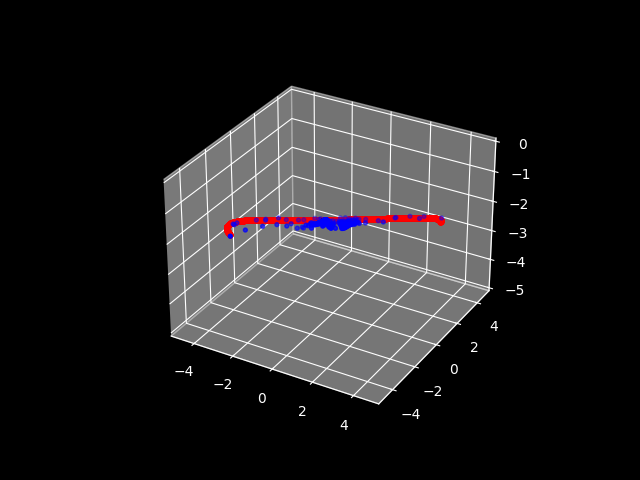

In [29]:
loadModel.eval()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(train_y[::2, 0].cpu().detach().numpy(), train_y[::2, 1].cpu(
).detach().numpy(), train_y[::2, 2].cpu().detach().numpy(), '.r')

y0 = train_y[0, :]
u0 = train_x[0, :4]
FuncDynamics.eval()
x = []
y = []
z = []
for i in range(TrainTrajectorySize):

    # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))
    u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
    m = deepcopy(train_y[i, :])
    m[0] += (np.random.uniform()-0.5)*3
    m[1] += (np.random.uniform()-0.5)*3
    m[2] += (np.random.uniform()-0.5)*3
    XDynamics = torch.cat(
        (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
    pred_y = loadModel(XDynamics).flatten()
    y0 = pred_y.to('cpu').detach().numpy()
    x.append(y0[0])
    y.append(y0[1])
    z.append(y0[2])

ax.scatter(x[0::2], y[::2], z[::2], s=8, c='b')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.gca().set_zlim([-5, 0])
plt.show()
